In [89]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

hex_color_list = ["#000004", "#1b0c41", "#4a0c6b", "#781c6d", "#a52c60", "#cf4446", "#ed6925", "#fb9b06", "#f7d13d", "#fcffa4"]

# Load Data

In [3]:
df_songs = pd.read_csv('Data/song_genre_data.csv')
df_users = pd.read_csv('Data/user_data.csv')
df_song_user = pd.read_csv('Data/song_user.csv')

# Data Cleaning

In [4]:
df_songs_clustering = df_song_user.drop_duplicates(subset=['song_id']).reset_index(drop=True)
df_songs_clustering = df_songs_clustering.drop(columns=['user_id', 'play_count'])
df_songs_clustering.shape

(3675, 18)

In [5]:
df_songs_clustering.isnull().sum()

song_id                 0
track_id                0
artist_id               0
song_title              0
artist_name             0
release                 0
artist_terms            0
artist_terms_freq       0
song_hotness          698
tempo                   0
loudness                0
duration                0
danceability            0
energy                  0
key                     0
mode                    0
year                    0
genre                1309
dtype: int64

In [6]:
# List of numerical and categorical columns with nan values
numerical_cols = ['song_hotness']
categorical_cols = ['genre']

# Fill NaNs in numerical columns with mean
for col in numerical_cols:
    df_songs_clustering[col].fillna(df_songs_clustering[col].mean(), inplace=True)

# Fill NaNs in categorical columns with mode
for col in categorical_cols:
    df_songs_clustering[col].fillna(df_songs_clustering[col].mode()[0], inplace=True)

In [7]:
clustering_features = ['tempo','loudness','duration','danceability','energy','key','mode']
df_clustering = df_songs_clustering[clustering_features]

In [30]:
# encoder = OneHotEncoder(sparse=False)
# # Fit and transform the 'genre' column
# encoded_genre = encoder.fit_transform(df_clustering[['genre']])
# encoded_genre_df = pd.DataFrame(encoded_genre, columns=encoder.get_feature_names_out(['genre']))

# # Concatenate the encoded genre DataFrame with the original DataFrame
# df_clustering = pd.concat([df_clustering.drop('genre', axis=1), encoded_genre_df], axis=1)

In [ ]:
# Scale the features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_clustering), columns=df_clustering.columns)
df_scaled.shape

(3675, 7)

# KMeans Clustering

## PCA

In [ ]:
pca = PCA(n_components=df_scaled.shape[1], random_state=42)
principalComponents = pca.fit_transform(df_scaled)

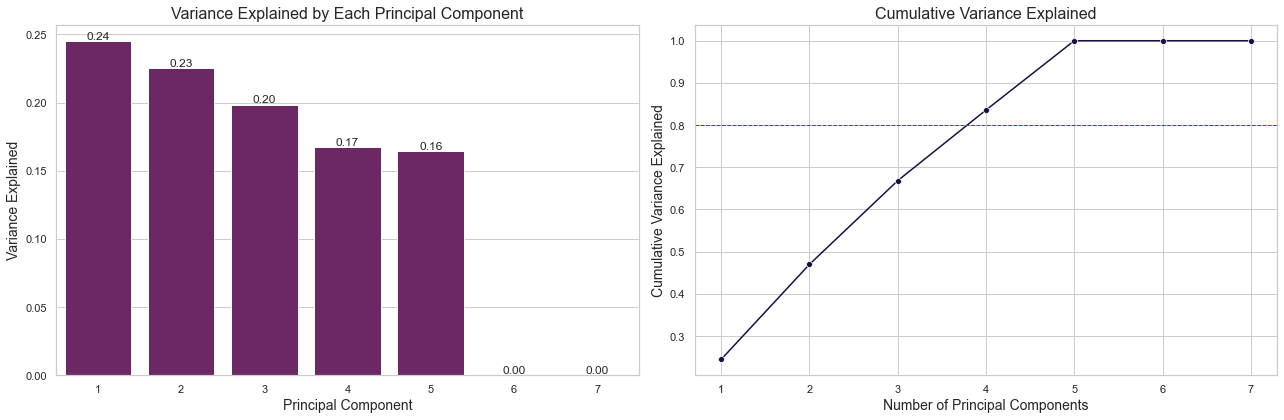

In [79]:
# Assuming `explained_variance` and `cumulative_variance` are already defined
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Set the style for Seaborn
sns.set_theme(style="whitegrid")

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
# fig.patch.set_facecolor('lightgrey')

# Variance explained plot
sns.barplot(x=list(range(1, len(explained_variance) + 1)), y=explained_variance, ax=axs[0], color=hex_color_list[3])
axs[0].set_title('Variance Explained by Each Principal Component', fontsize=16)
axs[0].set_xlabel('Principal Component', fontsize=14)
axs[0].set_ylabel('Variance Explained', fontsize=14)

# Add numbers on the bars
for i, variance in enumerate(explained_variance):
    axs[0].text(i, variance, f'{variance:.2f}', ha='center', va='bottom', fontsize=12)

# Cumulative variance explained plot
sns.lineplot(x=list(range(1, len(cumulative_variance) + 1)), y=cumulative_variance, ax=axs[1], marker='o', color= hex_color_list[1])
axs[1].set_title('Cumulative Variance Explained', fontsize=16)
axs[1].set_xlabel('Number of Principal Components', fontsize=14)
axs[1].set_ylabel('Cumulative Variance Explained', fontsize=14)

# Draw a horizontal line at 80% cumulative variance
axs[1].axhline(y=0.8, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()


In [21]:
num_pca = 4
df_pca = pd.DataFrame(principalComponents[:, :num_pca], columns=[f'PC{i+1}' for i in range(num_pca)])

In [72]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_pca)
    wcss.append(kmeans.inertia_)


In [23]:
silhouette_scores = []
davies_bouldin_indices = []

for i in range(2, 11):  
    kmeans = KMeans(n_clusters=i, random_state=42)
    cluster_labels = kmeans.fit_predict(df_pca)
    
    silhouette_scores.append(silhouette_score(df_pca, cluster_labels))
    davies_bouldin_indices.append(davies_bouldin_score(df_pca, cluster_labels))

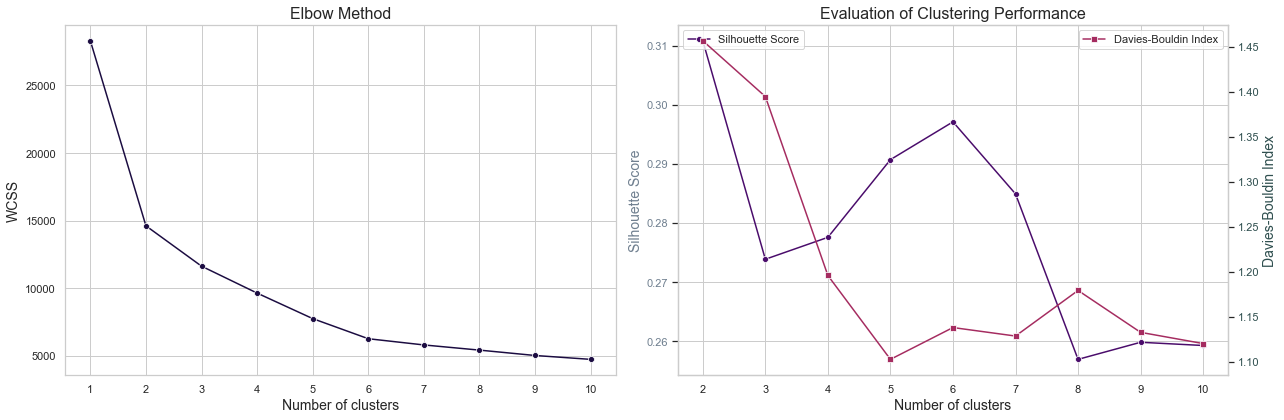

In [80]:
sns.set_theme(style="whitegrid")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Elbow Method plot with discrete x-axis
sns.lineplot(x=range(1, 11), y=wcss, marker='o', ax=ax1, color=hex_color_list[1])
ax1.set_xticks(range(1, 11))  # Ensure x-axis has all numbers as discrete values
ax1.set_title('Elbow Method', fontsize=16)
ax1.set_xlabel('Number of clusters', fontsize=14)
ax1.set_ylabel('WCSS', fontsize=14)

# Silhouette Score plot on the second subplot
sns.lineplot(x=range(2, 11), y=silhouette_scores, marker='o', color=hex_color_list[2], ax=ax2, label='Silhouette Score')
ax2.set_title('Evaluation of Clustering Performance', fontsize=16)
ax2.set_xlabel('Number of clusters', fontsize=14)
ax2.set_ylabel('Silhouette Score', color='slategray', fontsize=14)
ax2.tick_params(axis='y', labelcolor='slategray')

# Twin axis for Davies-Bouldin Index, with no grid
ax2_twin = ax2.twinx()
sns.lineplot(x=range(2, 11), y=davies_bouldin_indices, marker='s', color=hex_color_list[4], ax=ax2_twin, label='Davies-Bouldin Index')
ax2_twin.set_ylabel('Davies-Bouldin Index', color='darkslategray', fontsize=14)
ax2_twin.tick_params(axis='y', labelcolor='darkslategray')
ax2_twin.grid(False)  # Turn off grid for twin axis to reduce clutter

# Add legends
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

# Layout adjustment for clarity
fig.tight_layout()
plt.show()


In [47]:
optimal_k = 6 # Replace with the number determined from the Elbow Method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_pca['cluster'] = kmeans.fit_predict(df_pca) + 1

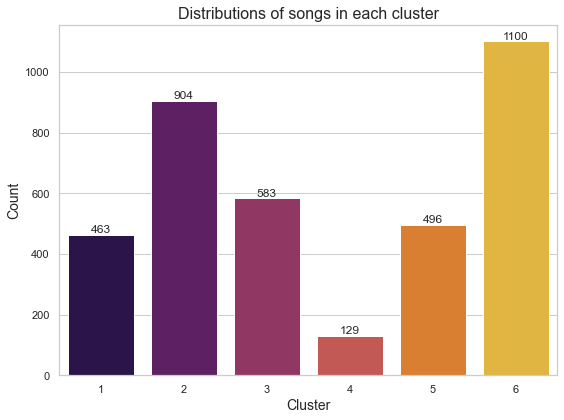

In [70]:
cluster_counts = df_pca['cluster'].value_counts().sort_index()
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='inferno')

# Add the count numbers on top of each bar
for i, count in enumerate(cluster_counts.values):
    ax.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=12)

# Set plot title and labels
ax.set_title('Distributions of songs in each cluster', fontsize=16)
ax.set_xlabel('Cluster', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


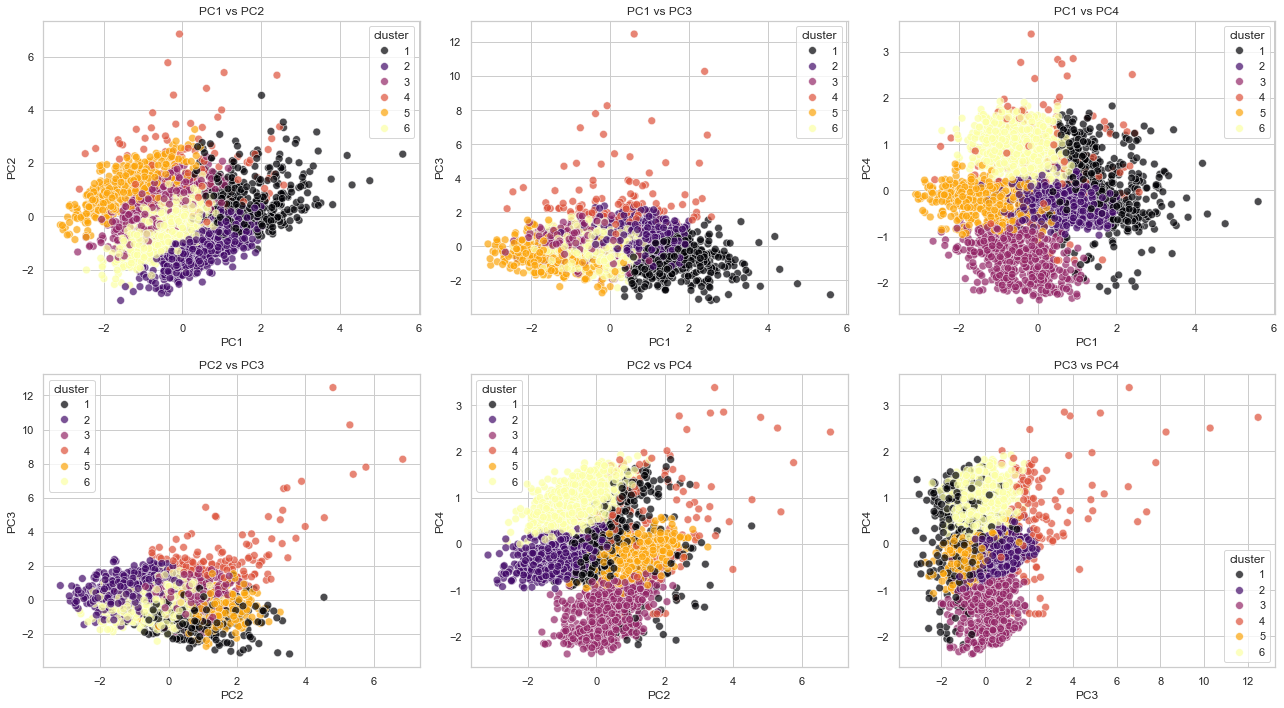

In [ ]:
# Set the style for Seaborn
sns.set_theme(style="whitegrid")

# Define the pairs of components to visualize
first_row_pairs = [('PC1', 'PC2'), ('PC1', 'PC3'), ('PC1', 'PC4')]
second_row_pairs = [('PC2', 'PC3'), ('PC2', 'PC4'), ('PC3', 'PC4')]

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loop over each pair for the first row
for i, (x_pc, y_pc) in enumerate(first_row_pairs):
    sns.scatterplot(
        x=x_pc, y=y_pc, hue='cluster', data=df_pca,
        palette='inferno', ax=axes[0, i], s=60, edgecolor='w', alpha=0.7
    )
    axes[0, i].set_title(f'{x_pc} vs {y_pc}')
    axes[0, i].set_xlabel(x_pc)
    axes[0, i].set_ylabel(y_pc)

# Loop over each pair for the second row
for i, (x_pc, y_pc) in enumerate(second_row_pairs):
    sns.scatterplot(
        x=x_pc, y=y_pc, hue='cluster', data=df_pca,
        palette='inferno', ax=axes[1, i], s=60, edgecolor='w', alpha=0.7  # rocket, magma, coolwarm, viridis, inferno
    )
    axes[1, i].set_title(f'{x_pc} vs {y_pc}')
    axes[1, i].set_xlabel(x_pc)
    axes[1, i].set_ylabel(y_pc)

# Adjust layout and show plot
fig.tight_layout()
plt.show()


# Make recommender system 

In [81]:
df_songs_clustering['cluster'] = df_pca['cluster'].values

In [82]:
df_songs_clustering.head(2)

,song_id,track_id,artist_id,song_title,artist_name,release,artist_terms,artist_terms_freq,song_hotness,tempo,loudness,duration,danceability,energy,key,mode,year,genre,cluster
0,SOWEZSI12A81C21CE6,TRAUCNU128F42671EB,AR2UQQ51187B9AC816,Tu Quieres Volver,Gipsy Kings,Greatest Hits,"['flamenco', 'soundtrack', 'folk', 'spanish', ...","[0.9085998342694063, 1.0, 0.974313019239368, 0...",0.778821,165.006,-8.403,194.87302,0.0,0.0,5,0,1987,Pop_Rock,3
1,SODCXXY12AB0187452,TRBFXMJ12903CB50F6,ARXLMH011C8A415658,Freaxxx,brokeNCYDE,BC 13-EP,"['pop rap', 'crunk', 'rapcore', 'screamo', 'br...","[1.0, 0.9259412500081688, 0.9259412500081688, ...",0.682113,119.612,-11.588,214.98730,0.0,0.0,1,1,2008,Pop_Rock,2


In [83]:
df_song_user.head(2)

,user_id,song_id,play_count,track_id,artist_id,song_title,artist_name,release,artist_terms,artist_terms_freq,song_hotness,tempo,loudness,duration,danceability,energy,key,mode,year,genre
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOWEZSI12A81C21CE6,1,TRAUCNU128F42671EB,AR2UQQ51187B9AC816,Tu Quieres Volver,Gipsy Kings,Greatest Hits,"['flamenco', 'soundtrack', 'folk', 'spanish', ...","[0.9085998342694063, 1.0, 0.974313019239368, 0...",0.778821,165.006,-8.403,194.87302,0.0,0.0,5,0,1987,NaN
1,833c530ecda3d99deb8395f70400aa3999783d91,SOWEZSI12A81C21CE6,2,TRAUCNU128F42671EB,AR2UQQ51187B9AC816,Tu Quieres Volver,Gipsy Kings,Greatest Hits,"['flamenco', 'soundtrack', 'folk', 'spanish', ...","[0.9085998342694063, 1.0, 0.974313019239368, 0...",0.778821,165.006,-8.403,194.87302,0.0,0.0,5,0,1987,NaN


In [84]:
def recommend_songs(user_id, song_id, df_songs, df_user_songs, num_recommendations=5):
    # Check if the song_id exists
    if song_id not in df_songs['song_id'].values:
        return [None] * num_recommendations  # Return placeholders if song_id is not found
    
    # Get the cluster of the given song
    song_cluster = df_songs.loc[df_songs['song_id'] == song_id, 'cluster'].values[0]
    
    # Get all songs in the same cluster
    cluster_songs = df_songs[df_songs['cluster'] == song_cluster]['song_id'].tolist()
    
    # Get all songs the user has already interacted with
    user_songs = df_user_songs[df_user_songs['user_id'] == user_id]['song_id'].tolist()
    
    # Exclude songs the user has already interacted with
    recommended_songs = list(set(cluster_songs) - set(user_songs))
    
    # Limit to the desired number of recommendations, adding None if fewer than required
    recommended_songs = (recommended_songs + [None] * num_recommendations)[:num_recommendations]
    
    return recommended_songs

# Create an empty list to store the results
recommendations_list = []

# Iterate through each row in df_user_songs to get recommendations
for index, row in df_song_user[:10].iterrows():
    user_id = row['user_id']
    song_id = row['song_id']
    
    # Get the recommendations
    recommendations = recommend_songs(user_id, song_id, df_songs_clustering, df_song_user)
    
    # Append the user_id, song_id, and recommendations to the list
    recommendations_list.append([user_id, song_id] + recommendations)

df_recommendations = pd.DataFrame(recommendations_list, columns=[
    'user_id', 'song_id', 'recommendation 1', 'recommendation 2', 
    'recommendation 3', 'recommendation 4', 'recommendation 5'
])

In [85]:
df_recommendations

,user_id,song_id,recommendation 1,recommendation 2,recommendation 3,recommendation 4,recommendation 5
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOWEZSI12A81C21CE6,SOZPMSM12AB018A95F,SOWMQNJ12A8AE471EE,SOUPNLN12A58A7CDDF,SOBVBID12A8AE474E3,SODNUSO12A8C13A9FE
1,833c530ecda3d99deb8395f70400aa3999783d91,SOWEZSI12A81C21CE6,SOZPMSM12AB018A95F,SOWMQNJ12A8AE471EE,SOUPNLN12A58A7CDDF,SOBVBID12A8AE474E3,SODNUSO12A8C13A9FE
2,d6c5bd2b570b4faf8964d7ed04f3392ff505d2be,SOWEZSI12A81C21CE6,SOZPMSM12AB018A95F,SOWMQNJ12A8AE471EE,SOUPNLN12A58A7CDDF,SOBVBID12A8AE474E3,SODNUSO12A8C13A9FE
3,724534729c9f5dc72a009269c2c225883e4775d2,SOWEZSI12A81C21CE6,SOZPMSM12AB018A95F,SOWMQNJ12A8AE471EE,SOUPNLN12A58A7CDDF,SOBVBID12A8AE474E3,SODNUSO12A8C13A9FE
4,ee7aa84c164038c963cfd02a7e52a5598aa470c3,SOWEZSI12A81C21CE6,SOZPMSM12AB018A95F,SOWMQNJ12A8AE471EE,SOUPNLN12A58A7CDDF,SOBVBID12A8AE474E3,SODNUSO12A8C13A9FE
5,1aa4fd215aadb160965110ed8a829745cde319eb,SOWEZSI12A81C21CE6,SOZPMSM12AB018A95F,SOWMQNJ12A8AE471EE,SOUPNLN12A58A7CDDF,SOBVBID12A8AE474E3,SODNUSO12A8C13A9FE
6,25de778286850a775207ae849df1004a1eeba820,SOWEZSI12A81C21CE6,SOZPMSM12AB018A95F,SOWMQNJ12A8AE471EE,SOUPNLN12A58A7CDDF,SOBVBID12A8AE474E3,SODNUSO12A8C13A9FE
7,bc28e2d36d80203392ed3e5a41ba3adf1de35f62,SOWEZSI12A81C21CE6,SOZPMSM12AB018A95F,SOWMQNJ12A8AE471EE,SOUPNLN12A58A7CDDF,SOBVBID12A8AE474E3,SODNUSO12A8C13A9FE
8,cca2694a19b2474bc731574ebb8b10382214f865,SOWEZSI12A81C21CE6,SOZPMSM12AB018A95F,SOWMQNJ12A8AE471EE,SOUPNLN12A58A7CDDF,SOBVBID12A8AE474E3,SODNUSO12A8C13A9FE
9,08d3508300b20c32738832e181ee12cf0b4089d8,SOWEZSI12A81C21CE6,SOZPMSM12AB018A95F,SOWMQNJ12A8AE471EE,SOUPNLN12A58A7CDDF,SOBVBID12A8AE474E3,SODNUSO12A8C13A9FE


# Validate Clustering & Recommender

# Split user data into training and testing data

In [118]:
# Get unique songs
df_song_val_clustering = df_song_user.drop_duplicates(subset=['song_id']).reset_index(drop=True)
df_song_val_clustering = df_song_val_clustering.drop(columns=['user_id', 'play_count'])

# Split songs into train and test songs (e.g., 80% train, 20% test)
train_songs, test_songs = train_test_split(
    df_song_val_clustering, test_size=0.2, random_state=42
)

# Assign interactions to train and test sets based on song assignment
train_data = df_song_user[df_song_user['song_id'].isin(train_songs['song_id'])].copy()
test_data = df_song_user[df_song_user['song_id'].isin(test_songs['song_id'])].copy()


In [122]:
clustering_features = ['tempo','loudness','duration','danceability','energy','key','mode']
df_val_clustering_train = train_songs[clustering_features]
scaler = StandardScaler()
df_val_clust_train_scaled = pd.DataFrame(scaler.fit_transform(df_val_clustering_train), columns=df_val_clustering_train.columns)
df_val_clust_train_scaled.shape

(2940, 7)

In [123]:
pca = PCA(n_components=df_scaled.shape[1], random_state=42)
principalComponents = pca.fit_transform(df_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

In [ ]:
optimal_k = 6 # Replace with the number determined from the Elbow Method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_pca['cluster'] = kmeans.fit_predict(df_pca) + 1

array([0.24476286, 0.46996736, 0.66836457, 0.83574636, 1.        ,
       1.        , 1.        ])

In [ ]:
def precision_at_k(recommended, test, k):
    recommended_k = recommended[:k]
    relevant = set(test)
    return len(set(recommended_k) & relevant) / k

def recall_at_k(recommended, test, k):
    recommended_k = recommended[:k]
    relevant = set(test)
    return len(set(recommended_k) & relevant) / len(relevant) if len(relevant) > 0 else 0

precision_scores = []
recall_scores = []

for user in test_set:
    recommended = generate_recommendations(user, train_set[user])  # Implement this function
    p = precision_at_k(recommended, test_set[user], K)
    r = recall_at_k(recommended, test_set[user], K)
    precision_scores.append(p)
    recall_scores.append(r)

avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)


In [ ]:
def precision_at_k(user_id, recommended_songs, user_interactions, k=5):
    # Get songs the user has actually interacted with
    actual_songs = user_interactions[user_interactions['user_id'] == user_id]['song_id'].tolist()
    
    # Count the number of recommendations that are in actual songs
    relevant_recommendations = len([song for song in recommended_songs[:k] if song in actual_songs])
    
    # Calculate precision at K
    precision = relevant_recommendations / k
    return precision


In [ ]:
# For demonstration, assuming df_user_songs has historical interactions for each user
precisions = []
for index, row in df_user_songs.iterrows():
    user_id = row['user_id']
    song_id = row['song_id']
    
    # Get recommendations for the user and song
    recommendations = recommend_songs(user_id, song_id, df_songs, df_user_songs)
    
    # Compute Precision@5
    precision = precision_at_k(user_id, recommendations, df_user_songs, k=5)
    precisions.append(precision)

# Calculate the average precision across all users
average_precision = sum(precisions) / len(precisions)
print(f"Average Precision@5: {average_precision}")
